In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class State:

    def __init__(self, n1, n2, n3, n4=None):

        self.player_current_sum = n1
        self.dealer_showing_card = n2
        self.player_usable_ace = n3
        self.action = n4


In [3]:
class BlackJack:

    def __init__(self):

        # Initialized state
        player_current_sum = 13
        dealer_showing_card = 2
        player_usable_ace = True
        self.initial_state = State(player_current_sum, dealer_showing_card, player_usable_ace)
        
        self.actions = ["hit","stick"]
        
        # Initialized dealer's policy and sum
        self.dealer_policy = dict()
        for i in range(17):
            self.dealer_policy[i] = "hit"
        for i in range(17, 22):
            self.dealer_policy[i] = "stick"
        self.dealer_current_sum = 0
        self.dealer_usable_ace = False
        self.dealer_not_showing_card = self.hit()
        if dealer_showing_card == 1 and self.dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 12
        elif dealer_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + self.dealer_not_showing_card
        elif self.dealer_not_showing_card == 1:
            self.dealer_usable_ace = True
            self.dealer_current_sum = 11 + dealer_showing_card
        else:
            self.dealer_usable_ace = False
            self.dealer_current_sum = dealer_showing_card + self.dealer_not_showing_card

    # Returns the card after hit action
    def hit(self):

        card = np.random.randint(1, 14)
        return min(10, card)

    def player_policy(self, type, player_current_sum):

        if type == "target": # Target policy
            if player_current_sum < 20:
                return "hit"
            else:
                return "stick"
        else: # Behavior policy
            return np.random.choice(self.actions)

    def play_game(self, policy_type):

        episode = list()
        current_state = self.initial_state
        
        # Player's turn
        
        while True:
            if current_state.action is None:
                current_state.action = self.player_policy(policy_type, current_state.player_current_sum)
            episode.append([current_state, current_state.action])
            player_current_sum = current_state.player_current_sum
            player_usable_ace = current_state.player_usable_ace

            if current_state.action == "hit":
                card = self.hit()
                if card == 1:
                    if current_state.player_usable_ace:
                        ace_count = 1
                    else:
                        ace_count = 0
                    ace_count += 1
                    player_current_sum = player_current_sum + 11
                    while player_current_sum > 21 and ace_count:
                        player_current_sum = player_current_sum - 10
                        ace_count -= 1
                    if player_current_sum > 21:
                        return episode, -1
                    if ace_count == 1:
                        player_usable_ace = True
                    else:
                        player_usable_ace = False
                else:
                    player_current_sum = current_state.player_current_sum + card
                if player_current_sum > 21 and player_usable_ace:
                    player_current_sum = player_current_sum - 10
                    player_usable_ace = False
                elif player_current_sum > 21:
                    return episode, -1
            else:
                break
            current_state = State(player_current_sum, current_state.dealer_showing_card, player_usable_ace)
        
        # Dealer's turn
        
        while True:
            dealer_action = self.dealer_policy[self.dealer_current_sum]
            if dealer_action == "hit":
                card = self.hit()
                if card == 1:
                    ace_count = 0
                    if self.dealer_usable_ace:
                        ace_count = 1
                    ace_count += 1
                    self.dealer_current_sum += 11
                    while self.dealer_current_sum > 21 and ace_count:
                        self.dealer_current_sum -= 10
                        ace_count -= 1
                    if self.dealer_current_sum > 21:
                        return episode, 1
                    if ace_count == 1:
                        self.dealer_usable_ace = True
                    else:
                        self.dealer_usable_ace = False
                else:
                    self.dealer_current_sum += card
                if self.dealer_current_sum > 21 and self.dealer_usable_ace:
                    self.dealer_current_sum = self.dealer_current_sum - 10
                    self.dealer_usable_ace = False
                elif self.dealer_current_sum > 21:
                    return episode, 1
            else:
                break

        if current_state.player_current_sum > self.dealer_current_sum:
            return episode, 1
        elif current_state.player_current_sum == self.dealer_current_sum:
            return episode, 0
        else:
            return episode, -1


In [4]:
class MonteCarloOffPolicy:

    def __init__(self,n):

        self.no_of_episodes = n
        self.rhos = np.zeros(n)
        self.returns = np.zeros(n)

    def off_policy(self):

        for i in range(self.no_of_episodes):
            black_jack_obj = BlackJack()
            episode, reward = black_jack_obj.play_game("behavior")
            numer_ = 1.0
            denom_ = 1.0
            t = len(episode)-1
            while t >= 0:
                s_t = episode[t][0]
                a_t = episode[t][1]
                if a_t == black_jack_obj.player_policy("target",s_t.player_current_sum):
                    denom_ = denom_*0.5
                else:
                    numer_ = 0
                    break
                t = t - 1
            rho = numer_/denom_
            self.rhos[i] = rho
            self.returns[i] = reward
        return np.add.accumulate(self.rhos * self.returns), np.add.accumulate(self.rhos)

    def importance_sampling(self,no_of_runs):

        true_value = -0.27726
        error_ordinary = np.zeros((no_of_runs, self.no_of_episodes))
        error_weighted = np.zeros((no_of_runs, self.no_of_episodes))
        for i in range(no_of_runs):
            weighted_returns, rhos = self.off_policy()
            ordinary_sampling = weighted_returns / np.arange(1, self.no_of_episodes+1)
            with np.errstate(divide='ignore', invalid='ignore'):
                ratio = weighted_returns/rhos
                weighted_sampling = np.where(rhos != 0, ratio, 0)
            error_ordinary[i] = np.power(ordinary_sampling - true_value, 2)
            error_weighted[i] = np.power(weighted_sampling - true_value, 2)
        return error_ordinary, error_weighted



In [5]:
def plot_fig_5_3():
    monte_carlo_obj = MonteCarloOffPolicy(10000)
    error_ordinary, error_weighted = monte_carlo_obj.importance_sampling(100)
    plt.plot(np.mean(error_ordinary, axis=0), label="Ordinary Importance Sampling")
    plt.plot(np.mean(error_weighted, axis=0), label="Weighted Importance Sampling")
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Episodes (log scale)")
    plt.ylabel("Mean square error")
    plt.savefig('figure_5_3.png')
    plt.show()
    plt.close()

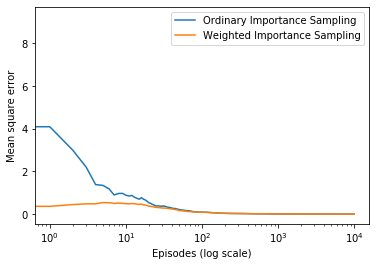

In [6]:
plot_fig_5_3()